In [65]:
# implement Nesterov's method for solving LASSO regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [66]:
# test it on the diabetes dataset from Efron, 2004
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
# implement Nesterov's method for solving LASSO regression
def nesterov_accelerated_gradient(y, X, lambda_, lr=0.01, max_iter=1000, tol=1e-6):
    
    def soft_thresholding(x, lambda_):
        return np.sign(x) * np.maximum(np.abs(x) - lambda_, 0.0)
    
    n, p = X.shape
    beta = np.zeros(p)
    beta_prev = np.zeros(p)
    t = 1
    t_prev = 1
    
    for iteration in range(max_iter):
        # Nesterov's update step
        y_tilde = beta + ((t_prev - 1) / t) * (beta - beta_prev)
        
        # Gradient of the smooth part
        gradient = -X.T.dot(y - X.dot(y_tilde)) / n
        
        # Update beta with a gradient step and soft-thresholding
        beta_prev = beta.copy()
        beta = soft_thresholding(y_tilde - lr * gradient, lr * lambda_)
        
        # Update t for the next iteration
        t_prev = t
        t = 0.5 * (1 + np.sqrt(1 + 4 * t ** 2))
        
        # Check for convergence
        if np.linalg.norm(beta - beta_prev, ord=2) < tol:
            break
    
    return beta

In [68]:
# try it on the diabetes dataset
lambda_ = 0.6
beta = nesterov_accelerated_gradient(y_train, X_train, lambda_)
print(mean_squared_error(y_test, X_test.dot(beta)))
print(beta)

26240.47305760641
[  0.          -0.         566.97185832 188.68829696  -0.
  -0.         -61.13930118  31.42747019 332.65176804  25.41631741]


In [69]:
# compare it with the LASSO implementation from scikit-learn
lasso = Lasso(alpha=lambda_)
lasso.fit(X_train, y_train)
print(mean_squared_error(y_test, lasso.predict(X_test)))
print(beta)

3011.0364551673497
[  0.          -0.         566.97185832 188.68829696  -0.
  -0.         -61.13930118  31.42747019 332.65176804  25.41631741]


In [70]:
# try LARS as an alternative to solve LASSO regression problem
from sklearn.linear_model import LassoLars
lasso = LassoLars(alpha=0.1)
lasso.fit(X_train, y_train)
print(mean_squared_error(y_test, lasso.predict(X_test)))
print(lasso.coef_)

2798.21723943795
[   0.         -152.65023467  552.72524653  303.3716212   -81.367213
    0.         -229.24749489    0.          447.91720513   29.63108487]


In [56]:
def lasso_objective(X, y, beta, lambda_):
    """
    Compute the LASSO objective function.
    """
    n = len(y)
    residual = y - np.dot(X, beta)
    loss = 0.5 * np.dot(residual, residual) / n
    penalty = lambda_ * np.linalg.norm(beta, ord=1)
    return loss + penalty


def lasso_gradient(X, y, beta, lambda_):
    """
    Compute the gradient of the LASSO objective function.
    """
    n = len(y)
    residual = y - np.dot(X, beta)
    gradient_loss = -np.dot(X.T, residual) / n
    gradient_penalty = lambda_ * np.sign(beta)
    return gradient_loss + gradient_penalty


def primal_gradient_descent(X, y, lambda_, learning_rate=0.01, max_iterations=1000, tol=1e-6):
    """
    Primal gradient descent for LASSO linear regression.
    """
    n, p = X.shape
    beta = np.zeros(p)  # Initialize coefficients
    loss_history = []

    for _ in range(max_iterations):
        gradient = lasso_gradient(X, y, beta, lambda_)
        beta -= learning_rate * gradient
        
        # Compute current loss
        loss = lasso_objective(X, y, beta, lambda_)
        loss_history.append(loss)
        
        # Check convergence
        if np.linalg.norm(gradient, ord=np.inf) < tol:
            break

    return beta, loss_history

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



def objective_function(X, y, beta, lambda_):
    prediction_error = y - X @ beta
    regularization_term = lambda_ * np.linalg.norm(beta, 1)
    objective_value = 0.5 * np.linalg.norm(prediction_error) ** 2 + regularization_term
    return objective_value

def gradient_of_f(X, y, beta):
    residuals = X @ beta - y
    gradient = X.T @ residuals
    return gradient

def G(vk, Lk, X, y, lambda_):
    """Gradient iteration for the dual problem as in (3.1.)."""
    grad_f_vk = gradient_of_f(X, y, vk)
    step_size = 1 / Lk
    vk1 = vk - step_size * grad_f_vk
    Mk = np.linalg.norm(grad_f_vk) + lambda_ * np.linalg.norm(vk1, 1)
    return vk1, Mk

def dual_gradient_method(X, y, v0, L0, gamma_d, lambda_, max_iter):
    vk = v0
    Lk = L0
    objective_values = []
    vk_values = [vk]

    for k in range(max_iter):
        vk1, Mk = G(vk, Lk, X, y, lambda_)
        Lk1 = max(L0, Mk / gamma_d)
        vk = vk1
        Lk = Lk1
        objective_values.append(objective_function(X, y, vk, lambda_))
        vk_values.append(vk)

    return vk, objective_values, np.array(vk_values)


In [57]:
# try primal gradient method for solving LASSO regression
lambda_ = 0.5
beta, loss_history = primal_gradient_descent(X_train, y_train, lambda_, max_iterations=4000)

for el in np.float16(beta):
    print(el)
    
print(len(loss_history))

13.516
-0.00469
71.75
47.94
1.386
0.003986
-36.2
37.66
61.34
43.12
4000


In [60]:
# try dual gradient method for solving LASSO regression
# n, p = X_train.shape
# v0 = np.zeros(n)
# L0 = np.linalg.norm(X_train, ord=2) ** 2 / n
# gamma_d = 1.1
# lambda_ = 0.5
# max_iter = 1000

# Setup and run the optimization
np.random.seed(0)
n_samples, n_features = 1000, 10
X = np.random.randn(n_samples, n_features)
y = np.dot(X, np.random.randn(n_features)) + np.random.randn(n_samples) * 0.1
lambda_ = 10
L0 = 1.0
gamma_d = 2.0
max_iter = 1000
v0 = np.zeros(n_features)  # Initial beta coefficients should be set, added this line

vk, objective_values, alpha_values = dual_gradient_method(X, y, v0, L0, gamma_d, lambda_, max_iter)


In [61]:
objective_values

[3358624089.8523383,
 3174012443.4662914,
 3169348268.613523,
 3164558998.9581246,
 3159773507.213276,
 3154991697.1640315,
 3150213568.792865,
 3145439122.010382,
 3140668356.727165,
 3135901272.853728,
 3131137870.3005123,
 3126378148.9778833,
 3121622108.796139,
 3116869749.665502,
 3112121071.4961243,
 3107376074.1980863,
 3102634757.681391,
 3097897121.855973,
 3093163166.631694,
 3088432891.918341,
 3083706297.6256285,
 3078983383.6631956,
 3074264149.940614,
 3069548596.367376,
 3064836722.8529034,
 3060128529.306543,
 3055424015.637568,
 3050723181.755178,
 3046026027.5685005,
 3041332552.986584,
 3036642757.9184103,
 3031956642.272879,
 3027274205.95882,
 3022595448.884987,
 3017920370.960059,
 3013248972.0926423,
 3008581252.1912646,
 3003917211.16438,
 2999256848.9203725,
 2994600165.3675404,
 2989947160.4141173,
 2985297833.9682536,
 2980652185.938029,
 2976010216.2314444,
 2971371924.7564273,
 2966737311.4208274,
 2962106376.132417,
 2957479118.798898,
 2952855539.32789,
 

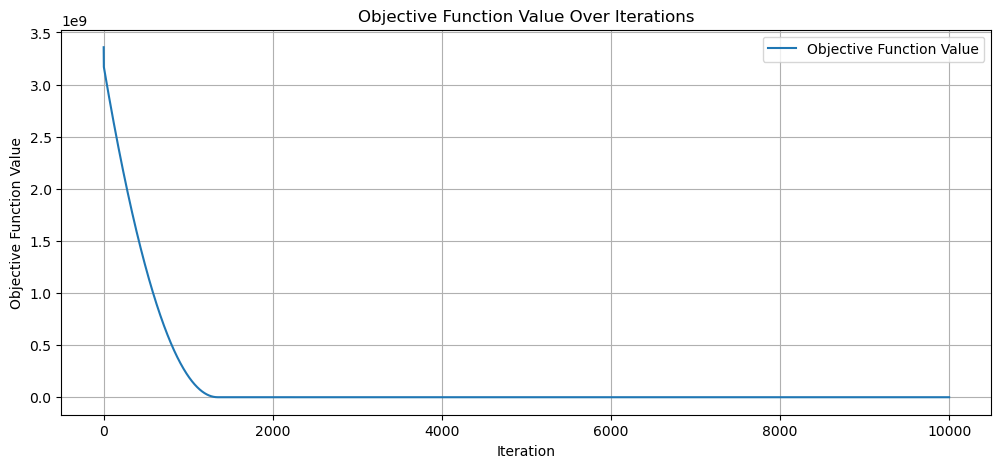

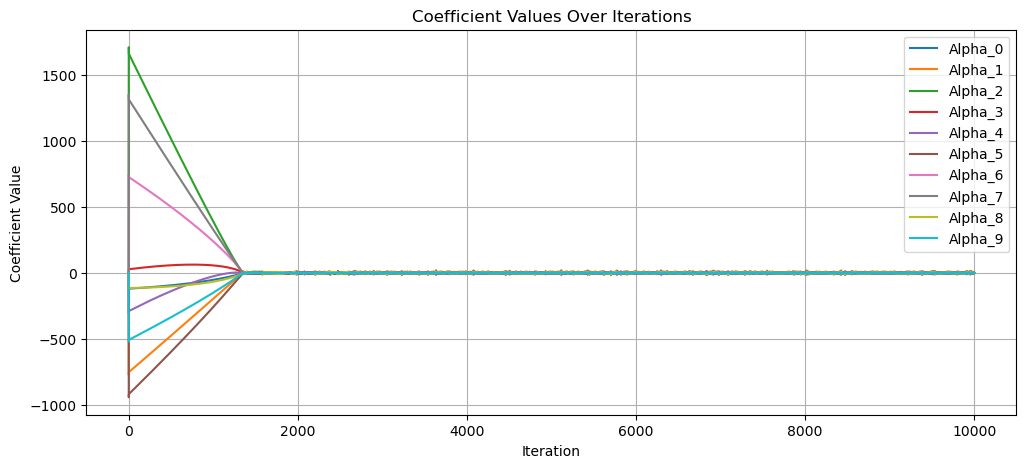

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def objective_function(X, y, beta, lambda_):
    prediction_error = y - X @ beta
    regularization_term = lambda_ * np.linalg.norm(beta, 1)
    objective_value = 0.5 * np.linalg.norm(prediction_error) ** 2 + regularization_term
    return objective_value

def gradient_of_f(X, y, beta):
    residuals = X @ beta - y
    gradient = X.T @ residuals
    return gradient

def G(vk, Lk, X, y, lambda_):
    grad_f_vk = gradient_of_f(X, y, vk)
    step_size = 1 / Lk
    vk1 = vk - step_size * grad_f_vk
    Mk = np.linalg.norm(grad_f_vk) + lambda_ * np.linalg.norm(vk1, 1)
    return vk1, Mk

def dual_gradient_method(X, y, v0, L0, gamma_d, lambda_, max_iter):
    vk = v0
    Lk = L0
    objective_values = []
    vk_values = [vk]

    for k in range(max_iter):
        vk1, Mk = G(vk, Lk, X, y, lambda_)
        Lk1 = max(L0, Mk / gamma_d)
        vk = vk1
        Lk = Lk1
        objective_values.append(objective_function(X, y, vk, lambda_))
        vk_values.append(vk)

    return vk, objective_values, np.array(vk_values)

# Setup and run the optimization
np.random.seed(0)
n_samples, n_features = 1000, 10
X = np.random.randn(n_samples, n_features)
y = np.dot(X, np.random.randn(n_features)) + np.random.randn(n_samples) * 0.1
lambda_ = 10
L0 = 1.0
gamma_d = 2.0
max_iter = 1000
v0 = np.zeros(n_features)  # Initial beta coefficients should be set, added this line

vk, objective_values, alpha_values = dual_gradient_method(X, y, v0, L0, gamma_d, lambda_, max_iter=10000)

# Plotting the objective function values over iterations
plt.figure(figsize=(12, 5))
plt.plot(objective_values, label='Objective Function Value')
plt.title('Objective Function Value Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the alpha coefficients over iterations
plt.figure(figsize=(12, 5))
for i in range(n_features):
    plt.plot(alpha_values[:, i], label=f'Alpha_{i}')
plt.title('Coefficient Values Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.show()


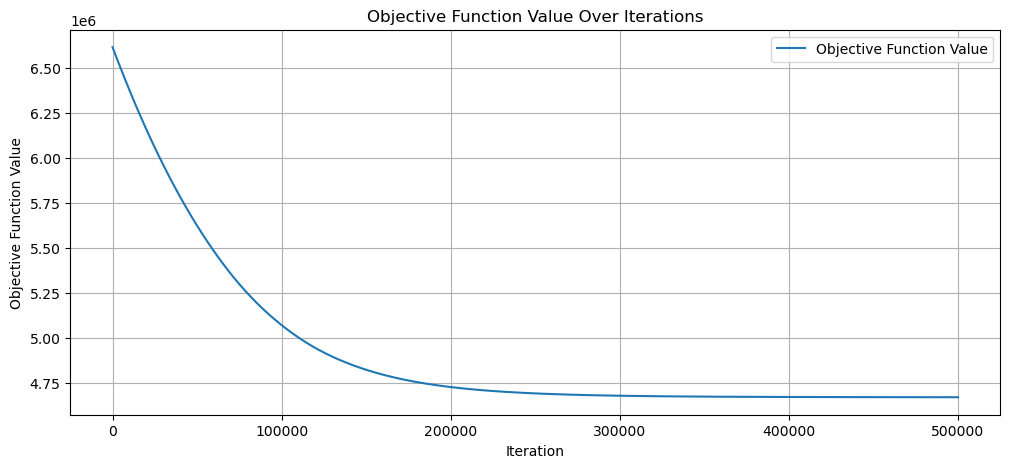

/home/bart_grabek/anaconda3/envs/aml_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


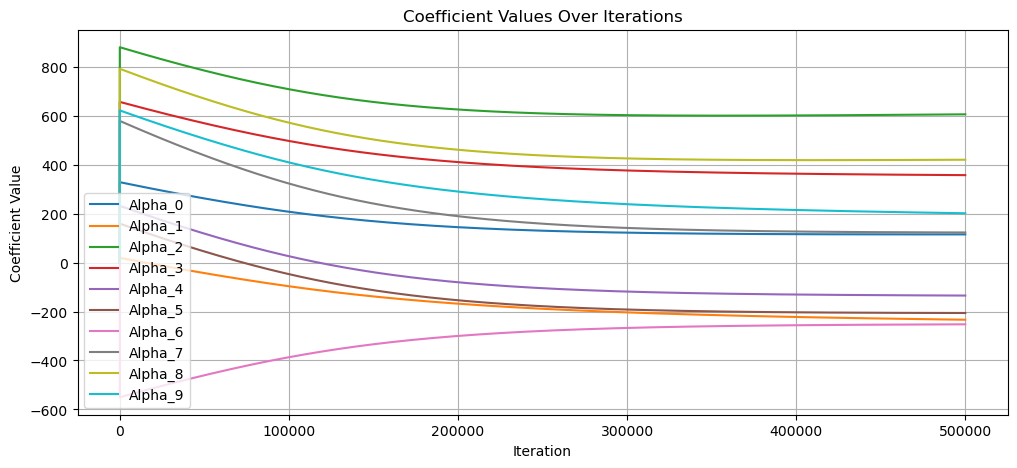

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def objective_function(X, y, beta, lambda_):
    prediction_error = y - X @ beta
    regularization_term = lambda_ * np.linalg.norm(beta, 1)
    objective_value = 0.5 * np.linalg.norm(prediction_error) ** 2 + regularization_term
    return objective_value

def gradient_of_f(X, y, beta):
    residuals = X @ beta - y
    gradient = X.T @ residuals
    return gradient

def G(vk, Lk, X, y, lambda_):
    grad_f_vk = gradient_of_f(X, y, vk)
    step_size = 1 / Lk
    vk1 = vk - step_size * grad_f_vk
    Mk = np.linalg.norm(grad_f_vk) + lambda_ * np.linalg.norm(vk1, 1)
    return vk1, Mk

def dual_gradient_method(X, y, v0, L0, gamma_d, lambda_, max_iter):
    vk = v0
    Lk = L0
    objective_values = []
    vk_values = [vk]

    for k in range(max_iter):
        vk1, Mk = G(vk, Lk, X, y, lambda_)
        Lk1 = max(L0, Mk / gamma_d)
        vk = vk1
        Lk = Lk1
        objective_values.append(objective_function(X, y, vk, lambda_))
        vk_values.append(vk)

    return vk, objective_values, np.array(vk_values)

# Setup and run the optimization
np.random.seed(0)
n_samples, n_features = X_train.shape
lambda_ = 50
L0 = 1.0
gamma_d = 0.5
max_iter = 1000
v0 = np.zeros(n_features)  # Initial beta coefficients should be set, added this line

vk, objective_values, alpha_values = dual_gradient_method(X_train, y_train, v0, L0, gamma_d, lambda_, max_iter=500000)

# Plotting the objective function values over iterations
plt.figure(figsize=(12, 5))
plt.plot(objective_values, label='Objective Function Value')
plt.title('Objective Function Value Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the alpha coefficients over iterations
plt.figure(figsize=(12, 5))
for i in range(n_features):
    plt.plot(alpha_values[:, i], label=f'Alpha_{i}')
plt.title('Coefficient Values Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.show()
